In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [126]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

n = 15
m = 450

kw = {
    'seed': 125396749,
    'speeds': [105],
    'chargers': list(range(1, 6)),
    'scale': (1e6, 1e6),
    'graph': {
        'directed': True,
    },
}

graph = src.rng.random_completely_connected_graph(
    n, m, **kw,
)

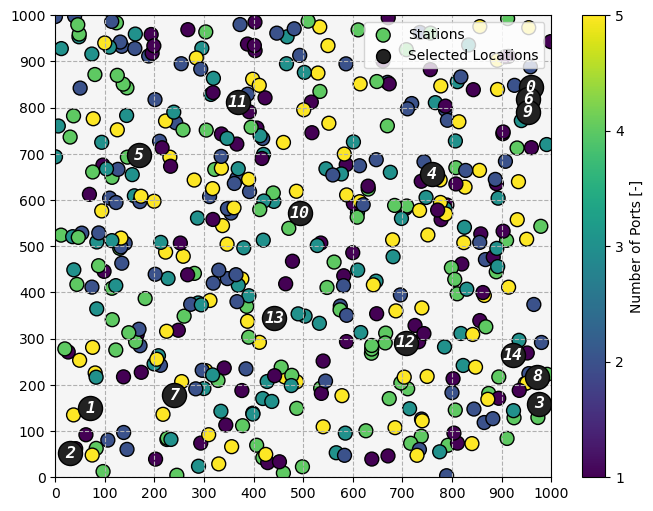

In [127]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [n for n in graph.nodes if 'destination' in n]
stations = [n for n in graph.nodes if 'station' in n]

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 100,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#222222',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(destinations, ax = ax, **kw)

x = [n['x'] for n in destinations._node.values()]
y = [n['y'] for n in destinations._node.values()]
n = [f'{n}' for n in range(destinations.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontweight': 'bold',
    'fontfamily': 'monospace',
    'color': '#ffffff'
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

In [132]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
rng = np.random.default_rng(seed)

cases = 1

station_kw = {}

station_kw['destination'] = {
    'cases': cases,
    'charge_rate': lambda rng: 6.6e3,
    'charge_price': lambda rng: .4 / 3.6e6,
    'setup_time': lambda rng: 0,
    'rng': rng,
}

station_kw['station'] = {
    'cases': cases,
    'charge_rate': lambda rng: 120e3,
    'charge_price': lambda rng: .5 / 3.6e6,
    'setup_time': lambda rng: 300,
    'queue_time': lambda rng: rng.random(cases) * 300,
    'rng': rng,
}

vehicle_kw = {
    'cases': cases,
    'risk_attitude': (0, 1),
}

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

In [129]:
deep_reload(src)

destinations = [k for k, v in graph._node.items() if v['type'] == 'destination']

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, [destinations[1]], objective = vehicle, destinations = destinations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 28.6923 seconds


In [130]:
costs

{'destination_0': 20136.222641265304,
 'destination_1': 0,
 'destination_2': 2595.652012161252,
 'destination_3': 16072.07593893368,
 'destination_4': 15207.313818456378,
 'destination_5': 10317.448371901288,
 'destination_6': 19812.124642335966,
 'destination_7': 3572.3937554975287,
 'destination_8': 16026.250037421949,
 'destination_9': 19525.142985785576,
 'destination_10': 10976.069260172953,
 'destination_11': 13096.966930329334,
 'destination_12': 11886.558428077578,
 'destination_13': 7634.403348587403,
 'destination_14': 15309.438083280998}

In [133]:
deep_reload(src)

destinations = [k for k, v in graph._node.items() if v['type'] == 'destination']

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, [destinations[1]], objective = vehicle, destinations = destinations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.4299 seconds


In [134]:
costs

{'destination_0': 19862.454402567128,
 'destination_1': 0,
 'destination_2': 2559.7148477115707,
 'destination_3': 15955.600293283522,
 'destination_4': 15064.05343549349,
 'destination_5': 10178.484603601348,
 'destination_6': 19547.60140939578,
 'destination_7': 3536.4565910478477,
 'destination_8': 15914.038455270902,
 'destination_9': 19270.391807273198,
 'destination_10': 10853.422871078854,
 'destination_11': 13025.922913430142,
 'destination_12': 11735.668760778175,
 'destination_13': 7598.466184137721,
 'destination_14': 15192.940809695705}

In [135]:
paths

{'destination_0': ['destination_1',
  'station_326',
  'station_373',
  'station_75',
  'destination_0'],
 'destination_1': ['destination_1'],
 'destination_2': ['destination_1', 'station_326', 'destination_2'],
 'destination_3': ['destination_1',
  'station_326',
  'station_198',
  'destination_3'],
 'destination_4': ['destination_1',
  'station_326',
  'station_146',
  'destination_4'],
 'destination_5': ['destination_1',
  'station_326',
  'station_144',
  'destination_5'],
 'destination_6': ['destination_1',
  'station_326',
  'station_373',
  'station_75',
  'destination_6'],
 'destination_7': ['destination_1', 'station_326', 'destination_7'],
 'destination_8': ['destination_1',
  'station_326',
  'station_198',
  'destination_8'],
 'destination_9': ['destination_1',
  'station_326',
  'station_373',
  'station_75',
  'destination_9'],
 'destination_10': ['destination_1',
  'station_326',
  'station_296',
  'destination_10'],
 'destination_11': ['destination_1',
  'station_326',
 